# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [2]:
output_featimp = 'feat_xgb_v18_reglinear_rooty.csv'
output_sub     = 'sub_xgb_v18_reglinear_rooty.csv'
output_oof     = 'oof_xgb_v18_reglinear_rooty.csv'

root = 2

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 10
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'reg:linear', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [4]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = train_df[TARGET]**(1/root)

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_40020\225736481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_40020\225736481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [5]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [6]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [7]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [8]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [9]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [10]:
## OOF target
oof_nfolds = 20

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_40020\1959937025.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_40020\1959937025.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [11]:
# modeling with cross validation
# kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
kfold = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)**(root)
    oof_test_skf[fold_id, :] = model.predict(d_test, ntree_limit=model.best_ntree_limit)**(root)

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, y_train**(root))))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], y_train[0:24069]**(root))))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], y_train[24069:]**(root))))


Fold 1 / 10
[19:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.12009	eval-rmse:10.95998
[100]	train-rmse:6.28142	eval-rmse:7.41964
[200]	train-rmse:4.45336	eval-rmse:6.50326
[300]	train-rmse:3.72149	eval-rmse:6.23879
[400]	train-rmse:3.35392	eval-rmse:6.08742
[500]	train-rmse:3.13335	eval-rmse:5.99333
[600]	train-rmse:2.98844	eval-rmse:5.93830
[700]	train-rmse:2.87897	eval-rmse:5.87393
[800]	train-rmse:2.78575	eval-rmse:5.82681
[900]	train-rmse:2.70473	eval-rmse:5.78299
[1000]	train-rmse:2.62681	eval-rmse:5.74421
[1100]	train-rmse:2.54885	eval-rmse:5.71371
[1200]	train-rmse:2.47660	eval-rmse:5.68508
[1300]	train-rmse:2.40223	eval-rmse:5.66029
[1400]	train-rmse:2.33418	eval-rmse:5.63899
[1500]	train-rmse:2.27052	eval-rmse:5.62275
[1600]	train-rmse:2.20686	eval-rmse:5.61526
[1700]	train-rmse:2.14095	eval-rmse:5.60593
[1800]	train-rmse:2.07949	ev

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 2 / 10
[19:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.14127	eval-rmse:10.73771
[100]	train-rmse:6.30019	eval-rmse:6.82299
[200]	train-rmse:4.47962	eval-rmse:5.70439
[300]	train-rmse:3.75948	eval-rmse:5.39855
[400]	train-rmse:3.39734	eval-rmse:5.31201
[500]	train-rmse:3.17618	eval-rmse:5.27102
[600]	train-rmse:3.02965	eval-rmse:5.25146
[700]	train-rmse:2.90888	eval-rmse:5.25003
[705]	train-rmse:2.90279	eval-rmse:5.24835

Fold 3 / 10
[19:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.08988	eval-rmse:11.20500


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.27547	eval-rmse:7.07402
[200]	train-rmse:4.43478	eval-rmse:6.11067
[300]	train-rmse:3.69214	eval-rmse:5.97107
[400]	train-rmse:3.30506	eval-rmse:5.95362
[482]	train-rmse:3.11102	eval-rmse:5.95271

Fold 4 / 10
[19:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.05448	eval-rmse:11.53927


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.29806	eval-rmse:7.18350
[200]	train-rmse:4.50863	eval-rmse:5.92625
[300]	train-rmse:3.78063	eval-rmse:5.62304
[400]	train-rmse:3.40572	eval-rmse:5.53979
[500]	train-rmse:3.16905	eval-rmse:5.50954
[510]	train-rmse:3.14763	eval-rmse:5.51099

Fold 5 / 10
[19:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.00799	eval-rmse:11.90206


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.19447	eval-rmse:7.84406
[200]	train-rmse:4.35175	eval-rmse:6.77601
[300]	train-rmse:3.60046	eval-rmse:6.50781
[400]	train-rmse:3.21894	eval-rmse:6.46036
[500]	train-rmse:2.98642	eval-rmse:6.44762
[519]	train-rmse:2.95528	eval-rmse:6.44409

Fold 6 / 10
[19:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.15336	eval-rmse:10.64258


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.25925	eval-rmse:6.56231
[200]	train-rmse:4.47567	eval-rmse:5.59727
[300]	train-rmse:3.74233	eval-rmse:5.34991
[400]	train-rmse:3.38727	eval-rmse:5.27187
[500]	train-rmse:3.16093	eval-rmse:5.23808
[600]	train-rmse:3.00379	eval-rmse:5.21335
[700]	train-rmse:2.88710	eval-rmse:5.19239
[800]	train-rmse:2.78507	eval-rmse:5.16531
[900]	train-rmse:2.69530	eval-rmse:5.15212
[1000]	train-rmse:2.61422	eval-rmse:5.14434
[1100]	train-rmse:2.53777	eval-rmse:5.13424
[1200]	train-rmse:2.46712	eval-rmse:5.12706
[1292]	train-rmse:2.39833	eval-rmse:5.12330

Fold 7 / 10
[19:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.12564	eval-rmse:10.89757


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.23706	eval-rmse:6.63265
[200]	train-rmse:4.44496	eval-rmse:5.60090
[300]	train-rmse:3.71245	eval-rmse:5.42438
[400]	train-rmse:3.34945	eval-rmse:5.39938
[499]	train-rmse:3.13139	eval-rmse:5.40361

Fold 8 / 10
[19:35:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.09618	eval-rmse:11.16534


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.22822	eval-rmse:6.94464
[200]	train-rmse:4.46198	eval-rmse:5.87389
[300]	train-rmse:3.72739	eval-rmse:5.63778
[400]	train-rmse:3.36667	eval-rmse:5.56659
[500]	train-rmse:3.13722	eval-rmse:5.54547
[600]	train-rmse:2.98192	eval-rmse:5.53539
[690]	train-rmse:2.88433	eval-rmse:5.53336

Fold 9 / 10
[19:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.07543	eval-rmse:11.34972


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.21707	eval-rmse:7.05982
[200]	train-rmse:4.46122	eval-rmse:5.94088
[300]	train-rmse:3.74386	eval-rmse:5.65090
[400]	train-rmse:3.38867	eval-rmse:5.56811
[500]	train-rmse:3.16180	eval-rmse:5.53728
[600]	train-rmse:3.00524	eval-rmse:5.52341
[700]	train-rmse:2.88562	eval-rmse:5.51006
[800]	train-rmse:2.78617	eval-rmse:5.50334
[900]	train-rmse:2.68568	eval-rmse:5.50111
[913]	train-rmse:2.67264	eval-rmse:5.50155

Fold 10 / 10
[19:35:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.15278	eval-rmse:10.62828


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.26454	eval-rmse:6.57402
[200]	train-rmse:4.48450	eval-rmse:5.68586
[300]	train-rmse:3.75501	eval-rmse:5.53962
[400]	train-rmse:3.39090	eval-rmse:5.51003
[500]	train-rmse:3.16650	eval-rmse:5.49189
[600]	train-rmse:3.01396	eval-rmse:5.48490
[700]	train-rmse:2.90085	eval-rmse:5.46845
[800]	train-rmse:2.80494	eval-rmse:5.44515
[900]	train-rmse:2.70957	eval-rmse:5.42904
[1000]	train-rmse:2.62224	eval-rmse:5.40909
[1100]	train-rmse:2.54384	eval-rmse:5.39674
[1200]	train-rmse:2.46948	eval-rmse:5.37688
[1292]	train-rmse:2.40352	eval-rmse:5.37171

OOF RMSE: 790.4026
OOF RMSE in 0:24069:   151.0588
OOF RMSE in 24069:END: 2563.5926


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0, 0.5, 'actual')

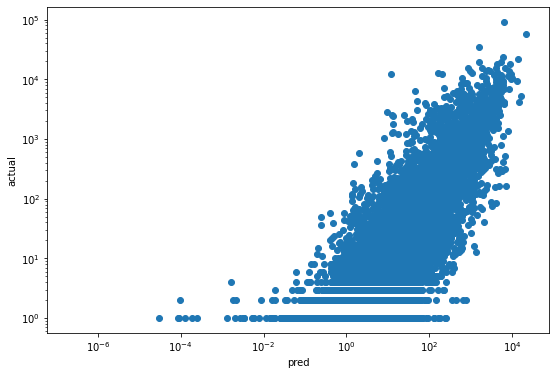

In [12]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, y_train**root)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

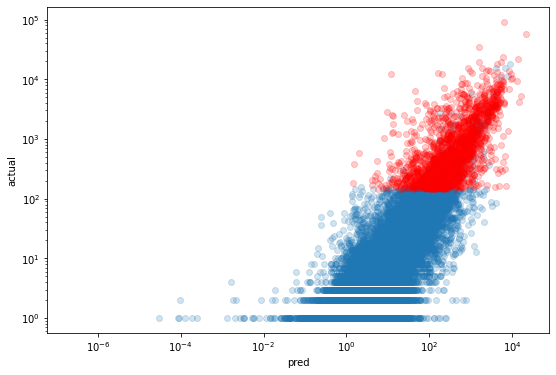

In [13]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], y_train[0:24069]**root, alpha=0.2)
plt.scatter(oof_train[24069:], y_train[24069:]**root, alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [14]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof['actual'] = y_train**root
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [16]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END